<a href="https://colab.research.google.com/github/earturor/timeseries/blob/main/timeseries_temp_nav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

In [11]:
data = np.loadtxt("https://raw.githubusercontent.com/earturor/timeseries/main/temp_nav.txt")

In [12]:
time = data[:, 0]
series = data[:, 1]

In [67]:
time[500]

33374.0

In [17]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time date from Jan 1 1990 to Apr 30 2016")
    plt.ylabel("Temperature °C")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [14]:
split_time = 7700
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

##Moving Avarage

In [15]:
def moving_average_forecast(series, window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1] / window_size

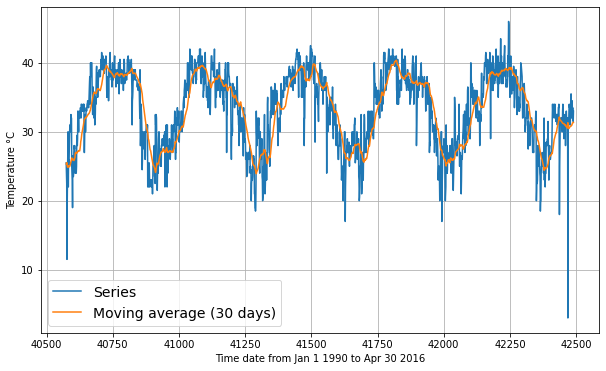

In [16]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [18]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

2.3762041384107113

##CNN

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [27]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

In [52]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32, kernel_size=2, strides=1,
                            dilation_rate=dilation_rate,
                            padding="causal", activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 1)          

In [53]:
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [54]:
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
60/60 [==============================] - 3s 28ms/step - loss: 29.9141 - mae: 30.4140 - val_loss: 11.1817 - val_mae: 11.6739
Epoch 2/500
60/60 [==============================] - 1s 18ms/step - loss: 9.4293 - mae: 9.9165 - val_loss: 3.1690 - val_mae: 3.6249
Epoch 3/500
60/60 [==============================] - 1s 19ms/step - loss: 2.4128 - mae: 2.8580 - val_loss: 1.6190 - val_mae: 2.0527
Epoch 4/500
60/60 [==============================] - 1s 19ms/step - loss: 1.3572 - mae: 1.7871 - val_loss: 1.0739 - val_mae: 1.4872
Epoch 5/500
60/60 [==============================] - 1s 21ms/step - loss: 1.0583 - mae: 1.4761 - val_loss: 1.0357 - val_mae: 1.4412
Epoch 6/500
60/60 [==============================] - 1s 19ms/step - loss: 1.0418 - mae: 1.4573 - val_loss: 1.0349 - val_mae: 1.4440
Epoch 7/500
60/60 [==============================] - 1s 18ms/step - loss: 1.0323 - mae: 1.4467 - val_loss: 1.0278 - val_mae: 1.4350
Epoch 8/500
60/60 [==============================] - 1s 19ms/step - loss

In [59]:
model = keras.models.load_model("my_checkpoint.h5")

In [91]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

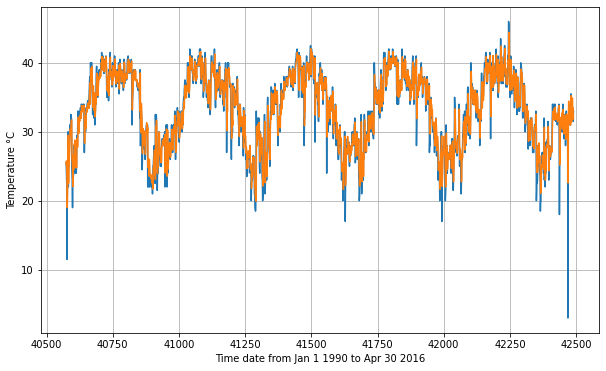

In [92]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [93]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

1.4279269